Determining cut-offs for high/low cases

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
wd = '~/Projects/RBDML'

In [5]:
case_df = pd.read_csv(os.path.join(wd, 'data/processed/case_data.csv'))
case_df.nunique()

country       13
adm1         160
year          31
month         12
num_cases    300
continent      4
disease        2
dtype: int64

There are 160 adm1/country combinations. First remove areas that have never had a case.

(array([23., 29., 33., 23., 23., 19., 13.,  1.,  0.,  1.]),
 array([ 0.        ,  1.23403369,  2.46806738,  3.70210107,  4.93613476,
         6.17016845,  7.40420214,  8.63823583,  9.87226952, 11.10630321,
        12.34033689]),
 <BarContainer object of 10 artists>)

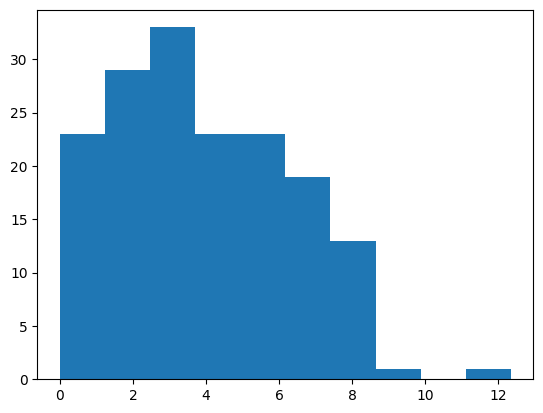

In [8]:
# sum case values for each group
case_sum = case_df.groupby(['country', 'adm1'])['num_cases'].sum()

# plot distribution
plt.hist(np.log(case_sum+1))

In [9]:
# only one area with 0 cases
case_sum.sort_values(ascending=False).tail(10)

country  adm1          
Nigeria  Akwa Ibom         1.0
USA      Rhode Island      1.0
Chile    Coquimbo          1.0
USA      Connecticut       1.0
Sweden   Kronoberg         1.0
USA      Maine             1.0
         New Hampshire     1.0
         Arkansas          1.0
         North Carolina    1.0
Sweden   Blekinge          0.0
Name: num_cases, dtype: float64

In [10]:
# Separate non-zero groups
nonz = case_sum[case_sum != 0].reset_index()

# Filter the original DataFrame based on non-zero groups
df = case_df[case_df[['country', 'adm1']].apply(tuple, axis=1).isin(nonz[['country', 'adm1']].apply(tuple, axis=1))]

# How many reduced by?
df.nunique()

country       13
adm1         159
year          31
month         12
num_cases    300
continent      4
disease        2
dtype: int64

Text(0, 0.5, 'Number of cases')

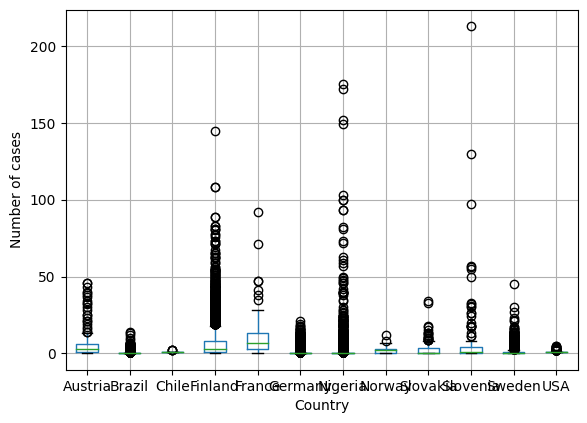

In [36]:
# what does the data look like by country
# remove China

df_s = df[df['country'] != 'China']
#df_s['log_case'] = np.log(df_s['num_cases']+ 1)
df_s.boxplot(column='num_cases', by='country')

# Customize the plot
plt.title('')
plt.suptitle('')
plt.xlabel('Country')
plt.ylabel('Number of cases')


(array([2.8195e+04, 2.8800e+02, 9.4000e+01, 1.3000e+01, 5.0000e+00,
        4.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <BarContainer object of 10 artists>)

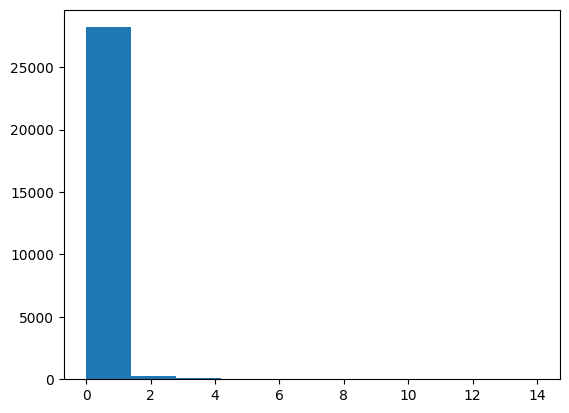

In [12]:
# look at hists
df_s = df[df['country'] == 'Brazil']

# plot distribution
plt.hist(df_s['num_cases'])

### Determining cut-offs for group

In [35]:
df.groupby(['country'])['num_cases'].agg(["mean", "std"])

,mean,std
country,,
Austria,6.750000,9.895109
Brazil,0.142637,0.456553
Chile,1.003096,0.055577
China,1016.613333,661.860113
Finland,6.080288,9.195806
France,10.280303,12.842151
Germany,0.104638,0.511395
Nigeria,1.161759,7.145598
Norway,1.988095,1.957599


In [30]:
#df['log_cases'] = np.log(df['num_cases']+ 1)

grouped = df.groupby('country')['num_cases']
outlier_cutoffs = grouped.describe(percentiles=[0.25, 0.75]).loc[:, ['25%', '75%']]
outlier_cutoffs['IQR'] = outlier_cutoffs['75%'] - outlier_cutoffs['25%']
outlier_cutoffs['Upper'] = outlier_cutoffs['75%'] + 1.5 * outlier_cutoffs['IQR']

# Create function to catego
def create_groups(row):
    middle_cutoff = outlier_cutoffs.loc[row['country'], '75%']
    upper_cutoff = outlier_cutoffs.loc[row['country'], 'Upper']
    
    if row['num_cases'] > upper_cutoff:
        return 'High'
    elif row['num_cases'] > middle_cutoff:
        return 'Medium'
    else:
        return 'Low'

In [26]:
df['group'] =  df.apply(create_groups, axis=1)


/var/folders/6v/qv38gbln47510l23__b6mzyrvfzcd1/T/ipykernel_96709/401058132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'] =  df.copy().apply(create_groups, axis=1)


In [28]:
df.head(10)

,country,adm1,year,month,num_cases,continent,disease,group
0,Brazil,Rondonia,2016,1,0.0,America,Hantavirus,Low
1,Brazil,Rondonia,2016,2,0.0,America,Hantavirus,Low
2,Brazil,Rondonia,2016,3,1.0,America,Hantavirus,High
3,Brazil,Rondonia,2016,4,0.0,America,Hantavirus,Low
4,Brazil,Rondonia,2016,5,0.0,America,Hantavirus,Low
5,Brazil,Rondonia,2016,6,0.0,America,Hantavirus,Low
6,Brazil,Rondonia,2016,7,0.0,America,Hantavirus,Low
7,Brazil,Rondonia,2016,8,0.0,America,Hantavirus,Low
8,Brazil,Rondonia,2016,9,0.0,America,Hantavirus,Low
9,Brazil,Rondonia,2016,10,0.0,America,Hantavirus,Low


In [31]:
outlier_cutoffs

,25%,75%,IQR,Upper
country,,,,
Austria,1.0,6.00,5.00,13.500
Brazil,0.0,0.00,0.00,0.000
Chile,1.0,1.00,0.00,1.000
China,553.0,1260.00,707.00,2320.500
Finland,1.0,8.00,7.00,18.500
France,3.0,13.00,10.00,28.000
Germany,0.0,0.00,0.00,0.000
Nigeria,0.0,0.00,0.00,0.000
Norway,0.0,3.00,3.00,7.500


Want to know: For each month (year?), high or low outbreak?

1. Convert to log-incidence
2. 